**Taken from https://github.com/ageron/handson-ml/blob/master/09_up_and_running_with_tensorflow.ipynb** 

**Book - https://www.amazon.com/gp/product/1491962291/ref=pe_240360_235570380_nrn_title**

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Creating and running a graph

### First phase - construct the graph

In [2]:
import tensorflow as tf

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [3]:
x

<tf.Variable 'x:0' shape=() dtype=int32_ref>

In [4]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

### Second phase - create a session and execute

In [5]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [6]:
sess.close()

Equivalent - create a global variable initializer and run it within a session:

In [7]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()

In [8]:
result

42

As an alternative, we can use an InteractiveSession that will set itself as the default session:

In [9]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)

42


In [10]:
sess.close() # cleanup

In [11]:
result

42

# sess.run evals multiple tensors in a single call

In [12]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [13]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z]) # evaluates both tensors in a single step
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Linear Regression

## Using the Normal Equation

In [14]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
print(housing.data.shape)
print(housing)

# Concatenate ones for bias dim
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

(20640, 8)
{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ..., 
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]]), 'target': array([ 4.526,  3.585,  3.521, ...,  0.923,  0.847,  0.894]), 'feature_names': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'], 'DESCR': 'California housing dataset.\n\nThe original database is available from StatLib\n\n    http://l

In [15]:
tf.reset_default_graph()

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

# See https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics)
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [16]:
theta_value

array([[ -3.74651413e+01],
       [  4.35734153e-01],
       [  9.33829229e-03],
       [ -1.06622010e-01],
       [  6.44106984e-01],
       [ -4.25131839e-06],
       [ -3.77322501e-03],
       [ -4.26648885e-01],
       [ -4.40514028e-01]], dtype=float32)

Compare with pure NumPy

In [17]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654266e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


Compare with Scikit-Learn

In [18]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


/Users/edavis/Downloads/pghml/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Regression for one feature

(500, 2)
[[ 0.60194445]
 [ 0.39888942]]


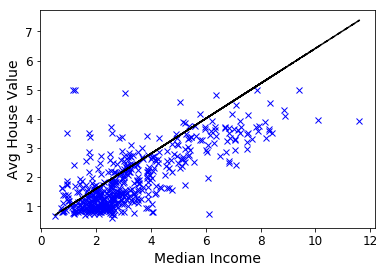

In [19]:
x_medinc, y_val = housing.data[:500,0], housing.target[:500] # Extract first 500 points for avg median income column
x_medinc_plus_bias = np.c_[np.ones((500, 1)), x_medinc.reshape(-1,1)] # Add bias column
print(x_medinc_plus_bias.shape)

tf.reset_default_graph()

X = tf.constant(x_medinc_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(y_val.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
print(theta_value)

# Slope and intercept
m, b = theta_value

# Plot the avg house value as a function of median income
plt.xlabel('Median Income')
plt.ylabel('Avg House Value')
plt.plot(x_medinc, y_val, 'bx', x_medinc, m*x_medinc+b, '--k')

## Using Batch Gradient Descent

Gradient Descent requires scaling the feature vectors first. We could do this using TF, but let's just use Scikit-Learn for now.

In [20]:
from sklearn.preprocessing import StandardScaler
m, n = housing.data.shape
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [21]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[  1.00000000e+00   6.60969987e-17   5.50808322e-18   6.60969987e-17
  -1.06030602e-16  -1.10161664e-17   3.44255201e-18  -1.07958431e-15
  -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ..., -0.06612179 -0.06360587
  0.01359031]
0.111111111111
(20640, 9)


### Manually computing the gradients

In [22]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta") # n+1 to account for bias
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)  # Update theta towards the opposite of the gradient direction
    
    best_theta = theta.eval()

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


In [23]:
best_theta

array([[  2.06855226e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845096e-01],
       [  1.64778158e-01],
       [  7.44080753e-04],
       [ -3.91945168e-02],
       [ -8.61356616e-01],
       [ -8.23479712e-01]], dtype=float32)

### Using autodiff - let TF calculate the gradients

Same as above except for the `gradients = ...` line:

In [24]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [25]:
# Op to calc the gradients of the mse loss wrt each parameter
gradients = tf.gradients(mse, [theta])[0]

In [26]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


### Using a `GradientDescentOptimizer`

In [27]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [28]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [29]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


# Saving and restoring a model

In [30]:
tf.reset_default_graph()

n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # not shown
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      # not shown
error = y_pred - y                                                                    # not shown
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # not shown
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            # not shown
training_op = optimizer.minimize(mse)                                                 # not shown

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                # not shown
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


In [31]:
best_theta

array([[  2.06855249e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845066e-01],
       [  1.64778143e-01],
       [  7.44078017e-04],
       [ -3.91945094e-02],
       [ -8.61356676e-01],
       [ -8.23479772e-01]], dtype=float32)

In [32]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()
    print(best_theta_restored)

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]
